# Aug 22 - Emulate Single Wavelength

GP emulation of 6S for a fixed wavelength.

In [71]:
from typing import Final

import alive_progress
import itertools
import matplotlib.pyplot as plt
import numpy as np
import rtm_wrapper.parameters as rtm_param
import scipy.stats.qmc as sci_qmc
import sklearn.gaussian_process as sklearn_gp
import sklearn.pipeline
import sklearn.preprocessing as sklearn_pre
from rtm_wrapper.engines.sixs import PySixSEngine, pysixs_default_inputs
from rtm_wrapper.execution import ConcurrentExecutor
from rtm_wrapper.simulation import SweepSimulation
import math


def unit2range(arr: np.ndarray, bot: float, top: float) -> np.ndarray:
    return arr * (top - bot) + bot

## Set wavelength and input parameter ranges

In [72]:
# Fixed wavelength to simulate.
WAVELENGTH: Final = 0.59  # micrometers

# Atmosphere parameter ranges to simulate.
OZONE_RANGE: Final = (0.25, 0.45)  # cm-atm
WATER_RANGE: Final = (1, 4)  # g/cm^2
AOT_RANGE: Final = (0.05, 0.5)  # 1
TARGET_ALT_RANGE: Final = (0.1, 30) # km

INPUT_RANGES: Final = {
    "atmosphere.ozone": OZONE_RANGE, 
    "atmosphere.water": WATER_RANGE, 
    "aerosol_profile.aot": AOT_RANGE, 
    # "altitude_target.value": TARGET_ALT_RANGE,
}

## Define base 6S inputs

In [77]:
base_inputs = pysixs_default_inputs().replace(
    atmosphere=rtm_param.AtmosphereWaterOzone(),
    aerosol_profile=rtm_param.AerosolAOTSingleLayer(profile="Maritime", height=100),
    # altitude_target=rtm_param.AltitudeKilometers(),
    wavelength__value=WAVELENGTH,
)

def param_rich_name(param_name: str) -> str:
    meta = base_inputs.get_metadata(param_name) 
    return f"{meta.get('title', param_name)} ({meta.get('unit', '?')})"

# Run true 6S simulation

## Sample atmosphere input ranges

In [74]:
# Number of LHS samples to draw.
NUM_SAMPLES: Final = 40

# Draw LHS samples.
rng = np.random.default_rng(2023_08_25)
lhs_sampler = sci_qmc.LatinHypercube(d=len(INPUT_RANGES), seed=rng)
raw_samples = lhs_sampler.random(NUM_SAMPLES)

# Draw Poisson disk samples
# pd_sampler = sci_qmc.PoissonDisk(d=2, seed=rng, radius=0.18)
# raw_samples = pd_sampler.random(NUM_SAMPLES)
# assert len(raw_samples) == NUM_SAMPLES, "failed to draw enough samples - try decreasing radius"

# Rescale LHS samples to parameter ranges.
input_samples = {
    input_name: unit2range(raw_samples[:, sample_column], *input_range)
    for sample_column, (input_name, input_range) in enumerate(INPUT_RANGES.items())
}

# Rescale LHS samples to parameter ranges.
# ozone_samples = unit2range(raw_samples[:, 0], *OZONE_RANGE)
# water_samples = unit2range(raw_samples[:, 1], *WATER_RANGE)
# # aot_samples = unit2range(raw_samples[:, 1], *AOT_RANGE)
# target_alt_samples  =unit2range(raw_samples[:, 2], TARGET_ALT_RANGE)

## Plot atmosphere input samples

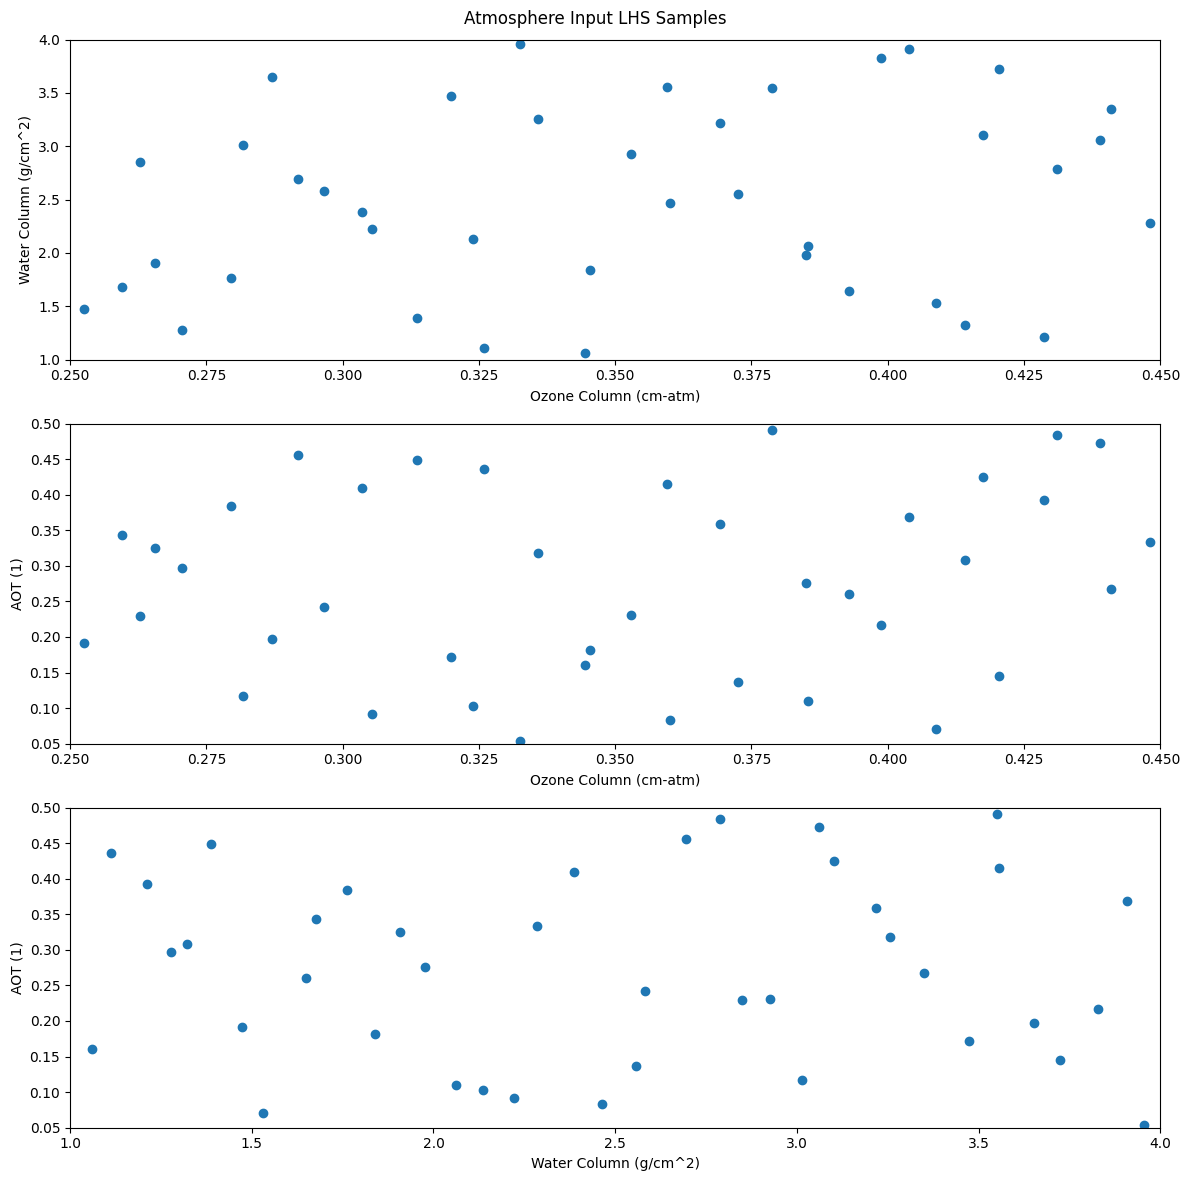

In [75]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
# ax.scatter(ozone_samples, water_samples, aot_samples)

param_combos = list(itertools.combinations(INPUT_RANGES.keys(), r=2))
ncols = math.floor(math.sqrt(len(param_combos)))
nrows = math.ceil(len(param_combos) / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

for ax, (param_x, param_y) in zip(axs.flat, param_combos):
    ax.scatter(input_samples[param_x], input_samples[param_y])
    ax.set_xlim(INPUT_RANGES[param_x])
    ax.set_ylim(INPUT_RANGES[param_y])
    ax.set_xlabel(param_rich_name(param_x))
    ax.set_ylabel(param_rich_name(param_y))

fig.suptitle("Atmosphere Input LHS Samples")
fig.tight_layout()

## Perform simulation

In [78]:
sweep = SweepSimulation(
    {
        "lhs": input_samples,
    },
    base=base_inputs,
)

engine = PySixSEngine()
runner = ConcurrentExecutor(max_workers=16)

with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
    runner.run(sweep, engine, step_callback=lambda _: bar())

train_results = runner.collect_results()
train_output = train_results.apparent_radiance

display(train_results)

|████████████████████████████████████████| 40/40 [100%] in 2.6s (15.38/s)       


<xarray.Dataset>
Dimensions:                        (lhs: 40)
Coordinates:
  * lhs                            (lhs) int64 0 1 2 3 4 5 ... 34 35 36 37 38 39
    atmosphere.ozone               (lhs) float64 0.4142 0.4088 ... 0.3259 0.2795
    atmosphere.water               (lhs) float64 1.321 1.53 ... 1.113 1.761
    aerosol_profile.aot            (lhs) float64 0.3075 0.07093 ... 0.3847
Data variables:
    transmittance_direct_down      (lhs) float64 0.6423 0.8449 ... 0.5538 0.5874
    apparent_radiance              (lhs) float64 119.1 120.1 ... 120.2 118.6
    transmittance_diffuse_up       (lhs) float64 0.3349 0.1438 ... 0.4199 0.3875
    transmittance_direct_up        (lhs) float64 0.6651 0.8562 ... 0.5801 0.6125
    transmittance_scattering_down  (lhs) float64 0.924 0.9511 ... 0.9088 0.9149
    transmittance_diffuse_down     (lhs) float64 0.2816 0.1062 ... 0.3551 0.3275
    transmittance_scattering_up    (lhs) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
Attributes:
    version:     0.2.0.dev0+373a83c
    platform:    CPython 3.10.12 (Linux atricapillus 6.2.0-26-generic #26~22....
    engine:      rtm_wrapper.engines.sixs.PySixSEngine
    base_repr:   Inputs(wavelength=WavelengthFixed(value=0.59), atmosphere=At...
    base_pzb64:  H4sIAJ7k6GQC/1VQzUoDMRBW0FpoQZHqMyhILz6A7MUqVir+0GOY7c5uAtlk...
    sim_start:   2023-08-25T13:27:56.225042-04:00
    sim_end:     2023-08-25T13:27:58.759835-04:00

## Plot scatter of outputs at each input

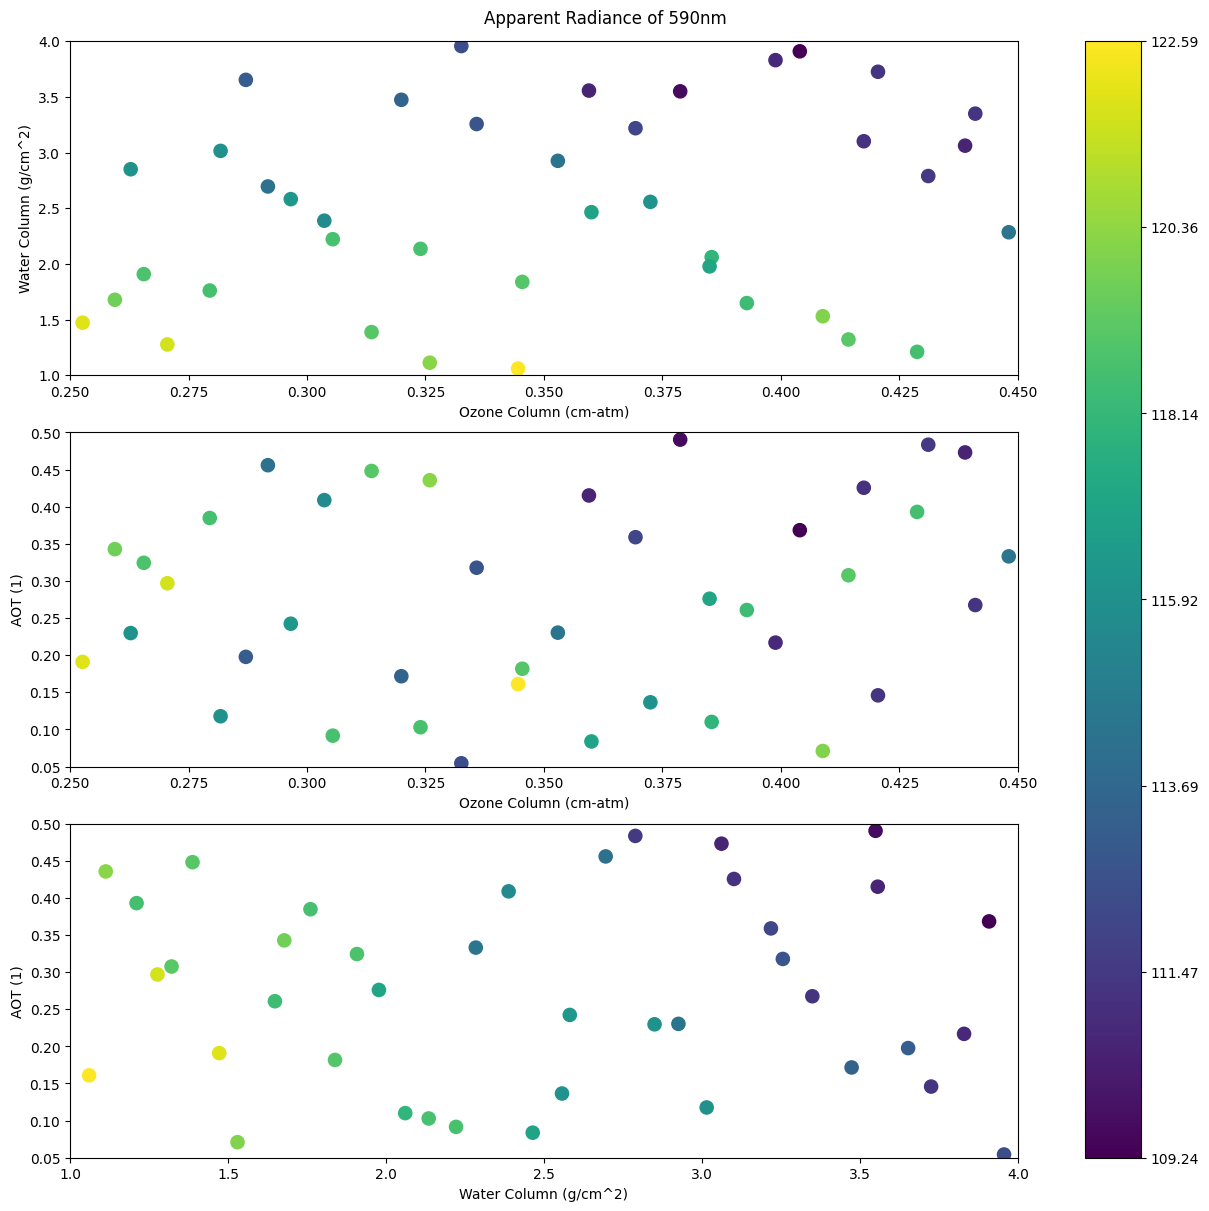

In [79]:
color_source = train_output.values
color = (color_source - color_source.min()) / (color_source.max() - color_source.min())

# fig, ax =  plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
# art = ax.scatter(
#     train_results.coords["atmosphere.ozone"].values,
#     train_results.coords["atmosphere.water"].values,
#     train_results.coords["aerosol_profile.aot"].values,
#     c=color,
#     s=90,
#     cmap="viridis",
# )
param_combos = list(itertools.combinations(INPUT_RANGES.keys(), r=2))
ncols = math.floor(math.sqrt(len(param_combos)))
nrows = math.ceil(len(param_combos) / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), layout="constrained")

for ax, (param_x, param_y) in zip(axs.flat, param_combos):
    art = ax.scatter(input_samples[param_x], input_samples[param_y], c=color, s=90)
    ax.set_xlim(INPUT_RANGES[param_x])
    ax.set_ylim(INPUT_RANGES[param_y])
    ax.set_xlabel(param_rich_name(param_x))
    ax.set_ylabel(param_rich_name(param_y))

n_ticks = 7
cbar = fig.colorbar(art, ax=axs, ticks=np.linspace(0, 1, n_ticks))
cbar.ax.set_yticklabels(
    np.round(np.linspace(color_source.min(), color_source.max(), n_ticks), 2)
)
fig.suptitle(f"Apparent Radiance of {WAVELENGTH*1000:.0f}nm");

# Train Emulator

## Extract training arrays

In [80]:
x_train = np.stack(
    [
        train_results.coords[parameter].values
        for parameter in INPUT_RANGES.keys()
    ],
    axis=-1,
)
y_train = train_output.values.reshape(-1, 1)
print(f"{x_train.shape=}, {y_train.shape=}")

x_train.shape=(40, 3), y_train.shape=(40, 1)


## Create GP model

In [133]:
kernel = 1.0 * sklearn_gp.kernels.RBF() # + sklearn_gp.kernels.WhiteKernel()
gaussian_process = sklearn_gp.GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1,
    # alpha=1,
    # Normalize targets to zero means, unit variance.
    normalize_y=True,
)

pipeline = sklearn.pipeline.Pipeline(
    [
        # Rescale input features to [0, 1].
        ("scale", sklearn_pre.MinMaxScaler()),
        ("gp", gaussian_process),
    ]
)
display(pipeline)
display(pipeline.named_steps["gp"].kernel.hyperparameters)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('gp',
                 GaussianProcessRegressor(alpha=1,
                                          kernel=1**2 * RBF(length_scale=1),
                                          n_restarts_optimizer=20,
                                          normalize_y=True))])

[Hyperparameter(name='k1__constant_value', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False)]

## Fit model

In [134]:
pipeline.fit(x_train, y_train)
display(pipeline.named_steps["gp"].kernel_)

1.93**2 * RBF(length_scale=1.36)

## Plot marginal likelihood surface

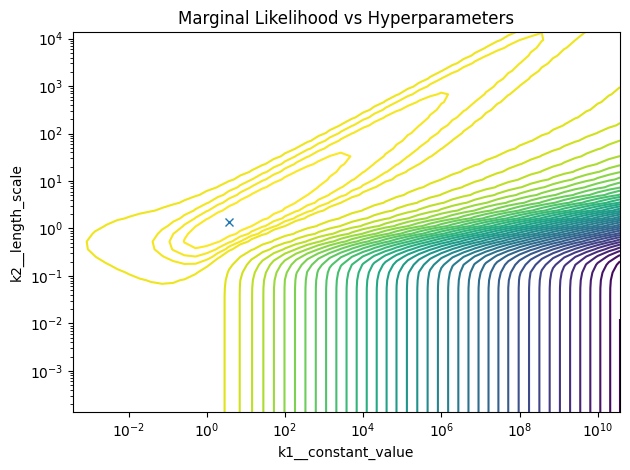

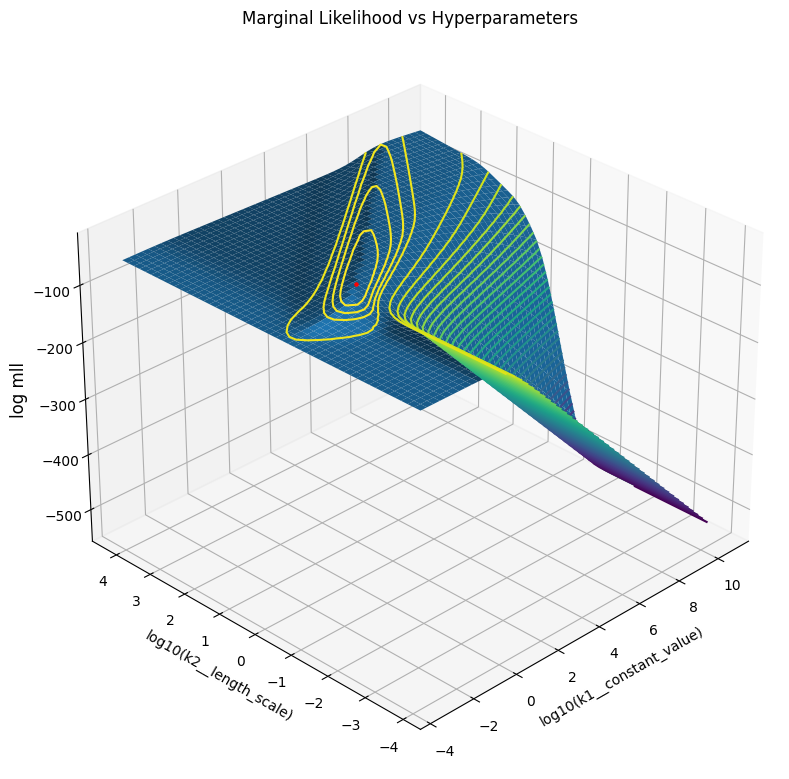

In [135]:
# Extract fit hyperparameter values.
fit_theta = pipeline.named_steps["gp"].kernel_.theta

# Indices of the two kernel hyperparameters to vary and plot MLL over. 
plot_hyper_idx = [0, 1]
plot_hyper_names = [gaussian_process.kernel.hyperparameters[idx].name for idx in plot_hyper_idx]

# Hyperparameter ranges to compute marginal likelihood over.
# Natural log scaled, and centered about fit hyperparameter values found above.
log_sweep_0 = np.log(10) * np.linspace(-4, 10, 50) + fit_theta[plot_hyper_idx[0]]
log_sweep_1 = np.log(10) * np.linspace(-4, 4, 50) + fit_theta[plot_hyper_idx[1]]


mesh_hyper_0, mesh_hyper_1 = np.meshgrid(log_sweep_0, log_sweep_1)
# Preallocate array for likelihood at each hyperparameter combination.
log_marginal_likelihoods = np.zeros(mesh_hyper_0.shape)

# Compute MLL for each hyperparameter combination.
for hyper_0, hyper_1, out in np.nditer(
    [mesh_hyper_0, mesh_hyper_1, log_marginal_likelihoods],
    op_flags=[["readonly"], ["readonly"], ["writeonly"]],
):
    theta = fit_theta.copy()
    theta[plot_hyper_idx[0]] = hyper_0
    theta[plot_hyper_idx[1]] = hyper_1
    out[...] = gaussian_process.log_marginal_likelihood(theta)

# Plot MLL contours.
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
# Pick contour levels. Increase level density near max to better show peaks.
peak_switch = np.percentile(log_marginal_likelihoods, 85)
levels = np.hstack(
    (
        np.linspace(log_marginal_likelihoods.min(), peak_switch, 40)[:-1],
        np.linspace(peak_switch, log_marginal_likelihoods.max(), 5),
    )
)
# levels = 30
art = ax.contour(
    np.exp(mesh_hyper_0), np.exp(mesh_hyper_1), log_marginal_likelihoods, levels
)
ax.plot(*np.exp(fit_theta), "x")
ax.set_xlabel(plot_hyper_names[0])
ax.set_ylabel(plot_hyper_names[1])
ax.set_title("Marginal Likelihood vs Hyperparameters")
fig.tight_layout()

# Plot 3D MLL surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))
ax.computed_zorder = False  # Prevent surface from hiding point, https://stackoverflow.com/q/51241367/11082165
ax.view_init(elev=30, azim=-135)
zlims = ax.get_zlim()
ax.scatter(
    [fit_theta[0] / np.log(10)],
    [fit_theta[1] / np.log(10)],
    [gaussian_process.log_marginal_likelihood(fit_theta)],
    c="r",
    s=5,
    zorder=2,
)
ax.plot_surface(
    mesh_hyper_0 / np.log(10),
    mesh_hyper_1 / np.log(10),
    log_marginal_likelihoods,
    # cmap="coolwarm",
    zorder=1,
)
ax.contour(
    mesh_hyper_0 / np.log(10),
    mesh_hyper_1 / np.log(10),
    log_marginal_likelihoods,
    levels=levels,
    zorder=3,
)

ax.set_xlabel(f"log10({plot_hyper_names[0]})")
ax.set_ylabel(f"log10({plot_hyper_names[1]})")
fig.supylabel("log mll")
ax.set_title("Marginal Likelihood vs Hyperparameters")
fig.tight_layout()

# Asses Emulator

## Generate test data

In [97]:
grid_size = 20

dense_input_test = {
    param_name: np.linspace(*param_range, grid_size)
    for param_name, param_range in INPUT_RANGES.items()
}

## Obtain actual sim results for test data

In [98]:
sweep = SweepSimulation(
    dense_input_test,
    base=base_inputs,
)

engine = PySixSEngine()
runner = ConcurrentExecutor(max_workers=16)
with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
    runner.run(sweep, engine, step_callback=lambda _: bar())

test_results = runner.collect_results()
test_output = test_results.apparent_radiance

display(test_output)

|████████████████████████████████████████| 8000/8000 [100%] in 7:19.2 (18.22/s) 


<xarray.DataArray 'apparent_radiance' (atmosphere.ozone: 20,
                                       atmosphere.water: 20,
                                       aerosol_profile.aot: 20)>
array([[[125.142, 125.004, 124.854, ..., 121.795, 121.557, 121.316],
        [124.393, 124.256, 124.107, ..., 121.066, 120.829, 120.59 ],
        [123.663, 123.526, 123.378, ..., 120.355, 120.12 , 119.882],
        ...,
        [114.499, 114.373, 114.236, ..., 111.437, 111.219, 110.998],
        [113.982, 113.856, 113.72 , ..., 110.933, 110.717, 110.497],
        [113.474, 113.349, 113.213, ..., 110.439, 110.223, 110.005]],

       [[124.97 , 124.832, 124.682, ..., 121.627, 121.39 , 121.149],
        [124.221, 124.084, 123.936, ..., 120.899, 120.663, 120.423],
        [123.492, 123.356, 123.208, ..., 120.189, 119.954, 119.716],
        ...,
        [114.341, 114.215, 114.078, ..., 111.283, 111.066, 110.845],
        [113.825, 113.699, 113.563, ..., 110.78 , 110.564, 110.345],
        [113.318, 113.192, 113.057, ..., 110.287, 110.071, 109.853]],

       [[124.797, 124.66 , 124.51 , ..., 121.46 , 121.222, 120.982],
        [124.05 , 123.913, 123.765, ..., 120.732, 120.496, 120.257],
        [123.322, 123.186, 123.038, ..., 120.023, 119.789, 119.551],
        ...,
...
        ...,
        [111.845, 111.722, 111.588, ..., 108.853, 108.641, 108.425],
        [111.34 , 111.217, 111.083, ..., 108.362, 108.15 , 107.936],
        [110.844, 110.721, 110.588, ..., 107.879, 107.668, 107.455]],

       [[122.073, 121.938, 121.792, ..., 118.808, 118.576, 118.341],
        [121.342, 121.208, 121.063, ..., 118.096, 117.866, 117.632],
        [120.63 , 120.496, 120.352, ..., 117.403, 117.174, 116.941],
        ...,
        [111.691, 111.567, 111.434, ..., 108.703, 108.491, 108.276],
        [111.186, 111.063, 110.93 , ..., 108.212, 108.001, 107.787],
        [110.691, 110.569, 110.436, ..., 107.73 , 107.52 , 107.306]],

       [[121.905, 121.77 , 121.624, ..., 118.644, 118.412, 118.177],
        [121.175, 121.041, 120.896, ..., 117.934, 117.703, 117.47 ],
        [120.463, 120.33 , 120.186, ..., 117.241, 117.012, 116.78 ],
        ...,
        [111.537, 111.414, 111.28 , ..., 108.554, 108.342, 108.127],
        [111.033, 110.91 , 110.777, ..., 108.063, 107.852, 107.638],
        [110.538, 110.416, 110.284, ..., 107.582, 107.371, 107.158]]])
Coordinates:
  * atmosphere.ozone     (atmosphere.ozone) float64 0.25 0.2605 ... 0.4395 0.45
  * atmosphere.water     (atmosphere.water) float64 1.0 1.158 ... 3.842 4.0
  * aerosol_profile.aot  (aerosol_profile.aot) float64 0.05 0.07368 ... 0.5
Attributes:
    title:    Apparent Radiance
    unit:     W/sr-m^2

In [99]:
import datetime
test_results.to_netcdf(f"test_dense_OzoneWaterAot_{datetime.datetime.now().isoformat()}.nc")

In [105]:
import xarray as xr
test_results = xr.open_dataset("test_dense_OzoneWaterAot_2023-08-25T13:39:55.912458.nc")
test_output = test_results.apparent_radiance
display(test_output)

<xarray.DataArray 'apparent_radiance' (atmosphere.ozone: 20,
                                       atmosphere.water: 20,
                                       aerosol_profile.aot: 20)>
[8000 values with dtype=float64]
Coordinates:
  * atmosphere.ozone     (atmosphere.ozone) float64 0.25 0.2605 ... 0.4395 0.45
  * atmosphere.water     (atmosphere.water) float64 1.0 1.158 ... 3.842 4.0
  * aerosol_profile.aot  (aerosol_profile.aot) float64 0.05 0.07368 ... 0.5
Attributes:
    title:    Apparent Radiance
    unit:     W/sr-m^2

## Extract test arrays

In [136]:
dense_input_meshes = np.meshgrid(
    *dense_input_test.values(),
    indexing="ij",
)

x_test = np.hstack([mesh.reshape(-1, 1) for mesh in dense_input_meshes])
y_test = test_output.values.reshape(-1, 1)

# x_test[:, 0] = 0.3  # verify axes match by making ozone constant

print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=(8000, 3), y_test.shape=(8000, 1)


## Evaluate model on test data

In [137]:
pred_mean, pred_std = pipeline.predict(x_test, return_std=True)
pred_error = y_test - pred_mean.reshape(-1, 1)

pred_mean = pred_mean.reshape(dense_input_meshes[0].shape)
pred_std = pred_std.reshape(dense_input_meshes[0].shape)
pred_error = pred_error.reshape(dense_input_meshes[0].shape)
y_test_shaped = y_test.reshape(dense_input_meshes[0].shape)

## Compute metrics

In [138]:
rmse = np.sqrt(np.mean(pred_error**2))

abs_error = np.abs(pred_error)

print(f"RMSE: {rmse:0.2f}")
print(f"Avg abs err: {np.mean(abs_error):0.2f}")
print(f"Max abs err: {np.max(abs_error):0.2f}")
print(f"Avg rel err: {np.mean(abs_error/y_test_shaped):0.2%}")
print(f"Max rel err: {np.max(abs_error/y_test_shaped):0.2%}")

RMSE: 0.61
Avg abs err: 0.47
Max abs err: 2.62
Avg rel err: 0.41%
Max rel err: 2.09%


## Plot posterior mean, std, error

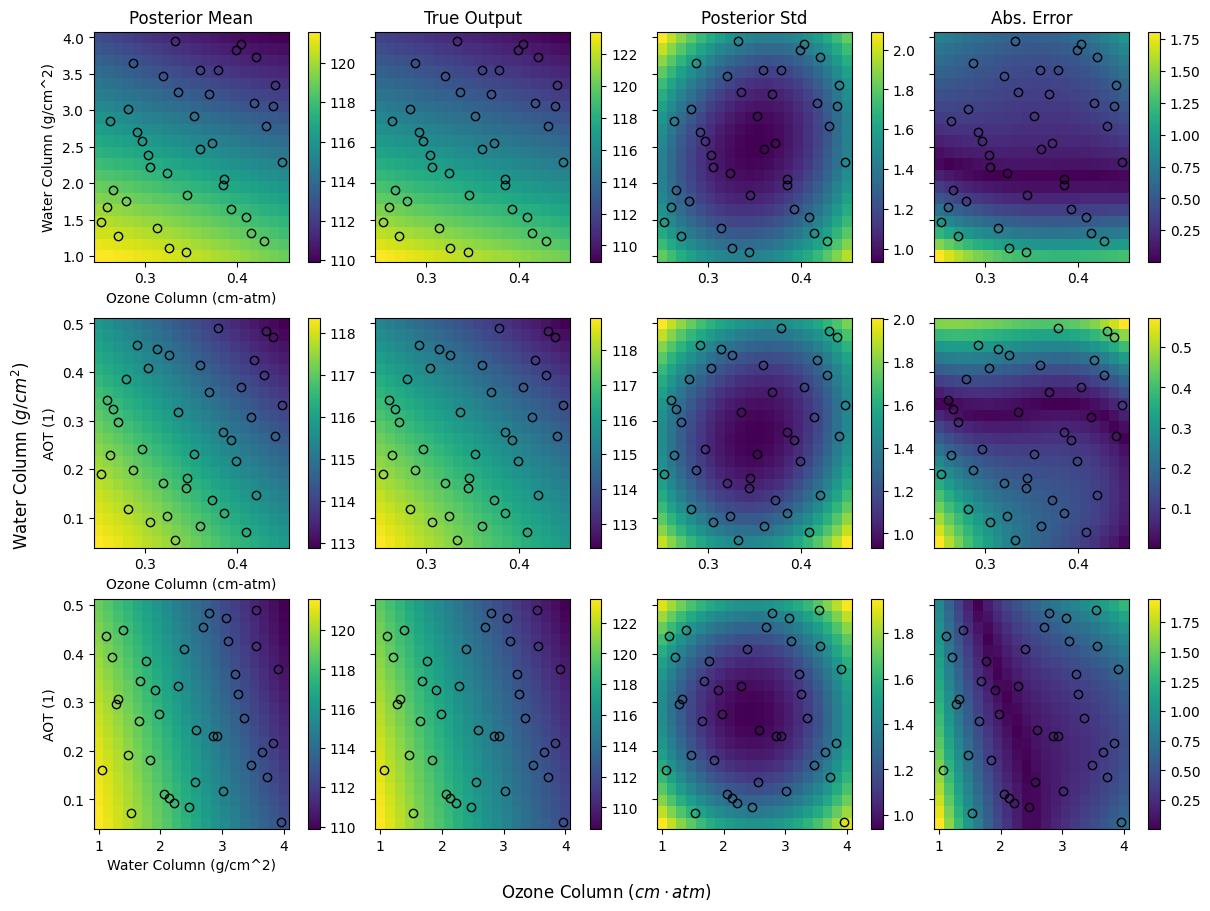

In [139]:
param_idx_combos = list(itertools.combinations(range(len(INPUT_RANGES)), r=2))
param_names = list(INPUT_RANGES.keys())
fig, axs = plt.subplots(nrows=len(param_combos), ncols=4, figsize=(12, 3*len(INPUT_RANGES)), sharex="row", sharey="row", layout="constrained")


for ax_row, (param_x_idx, param_y_idx) in zip(axs, param_idx_combos):
    
    local_mesh_x, local_mesh_y = np.meshgrid(
        dense_input_test[param_names[param_x_idx]],
        dense_input_test[param_names[param_y_idx]],
        indexing="ij",
    )
    
    other_dims = tuple(i for i in range(len(INPUT_RANGES)) if i not in (param_x_idx, param_y_idx))

    pred_mean_only = pred_mean.mean(axis=other_dims)
    y_test_only =y_test_shaped.mean(axis=other_dims)
    pred_std_only = pred_std.mean(axis=other_dims)
    pred_error_only = pred_error.mean(axis=other_dims)
    
    # Plot predicted mean surface.
    ax = ax_row[0]
    art = ax.pcolormesh(local_mesh_x, local_mesh_y, pred_mean_only)
    ax.plot(input_samples[param_names[param_x_idx]], input_samples[param_names[param_y_idx]], "o", color="k", markerfacecolor="none",)
    
    cbar = fig.colorbar(art)
    
    # Plot true output surface.
    ax = ax_row[1]
    art = ax.pcolormesh(local_mesh_x, local_mesh_y, y_test_only)
    ax.plot(input_samples[param_names[param_x_idx]], input_samples[param_names[param_y_idx]], "o", color="k", markerfacecolor="none",)
    
    fig.colorbar(art)
    
    # Plot predicted variance surface.
    ax = ax_row[2]
    art = ax.pcolormesh(local_mesh_x, local_mesh_y, pred_std_only)
    ax.plot(input_samples[param_names[param_x_idx]], input_samples[param_names[param_y_idx]], "o", color="k", markerfacecolor="none",)
   
    fig.colorbar(art)
    
    # Plot error surface.
    ax = ax_row[3]
    art = ax.pcolormesh(local_mesh_x, local_mesh_y, np.abs(pred_error_only))
    ax.plot(input_samples[param_names[param_x_idx]], input_samples[param_names[param_y_idx]], "o", color="k", markerfacecolor="none",)
   
    fig.colorbar(art)
    
    ax_row[0].set_xlabel(param_rich_name(param_names[param_x_idx]))
    ax_row[0].set_ylabel(param_rich_name(param_names[param_y_idx]))
    
axs[0,0].set_title("Posterior Mean")
axs[0,1].set_title("True Output")
axs[0,2].set_title("Posterior Std")
axs[0,3].set_title("Abs. Error")


fig.supxlabel("Ozone Column ($cm\cdot atm$)")
fig.supylabel("Water Column ($g/cm^2$)");